In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
with open('Downloads/user-wallet-transactions.json', 'r') as file:
    transactions = json.load(file)


In [4]:
records = []
for tx in transactions:
    records.append({
        'wallet': tx.get('wallet_address'),
        'tx_type': tx.get('transaction_type'),
        'amount': float(tx.get('amount', 0)),
        'timestamp': tx.get('timestamp', None)
    })

df = pd.DataFrame(records)

In [6]:
df = pd.DataFrame(transactions)
print(df.head())




                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...   

 

In [7]:
import pandas as pd

# Extract 'amount' from nested actionData
df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)) if isinstance(x, dict) else 0)

# Optional: Convert raw amounts from Wei (if using Ethereum units) to Ether
df['amount'] = df['amount'] / 1e18

# Select required columns
df_clean = df[['userWallet', 'action', 'amount', 'timestamp']].copy()

# Rename for consistency
df_clean.columns = ['wallet', 'tx_type', 'amount', 'timestamp']

# Check data
print(df_clean.head())


                                       wallet           tx_type        amount  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit  2.000000e-09   
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit  1.450000e+02   
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  1.000000e-03   
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  4.000000e-03   
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying  5.015480e-13   

    timestamp  
0  1629178166  
1  1621525013  
2  1627118913  
3  1627773318  
4  1618845907  


In [8]:
# Assuming df_clean is already prepared

# Basic aggregations
wallet_stats = df_clean.groupby('wallet').agg(
    total_deposits=('amount', lambda x: x[df_clean.loc[x.index, 'tx_type'] == 'deposit'].sum()),
    total_borrows=('amount', lambda x: x[df_clean.loc[x.index, 'tx_type'] == 'borrow'].sum()),
    total_repayments=('amount', lambda x: x[df_clean.loc[x.index, 'tx_type'] == 'repay'].sum()),
    total_redeems=('amount', lambda x: x[df_clean.loc[x.index, 'tx_type'] == 'redeemunderlying'].sum()),
    total_liquidations=('amount', lambda x: x[df_clean.loc[x.index, 'tx_type'] == 'liquidationcall'].sum()),
    transaction_count=('tx_type', 'count'),
    avg_tx_amount=('amount', 'mean')
).fillna(0)

# Behavior ratios
wallet_stats['deposit_borrow_ratio'] = wallet_stats['total_deposits'] / (wallet_stats['total_borrows'] + 1)
wallet_stats['repay_borrow_ratio'] = wallet_stats['total_repayments'] / (wallet_stats['total_borrows'] + 1)
wallet_stats['liquidation_penalty_ratio'] = wallet_stats['total_liquidations'] / (wallet_stats['total_borrows'] + 1)

# View engineered features
print(wallet_stats.head())


                                            total_deposits  total_borrows  \
wallet                                                                      
0x00000000001accfa9cef68cf5371a23025b6d4b6    2.000000e-09            0.0   
0x000000000051d07a4fb3bd10121a343d85818da6    1.450000e+02            0.0   
0x000000000096026fb41fc39f9875d164bd82e2dc    5.000000e-03            0.0   
0x0000000000e189dd664b9ab08a33c4839953852c    0.000000e+00            0.0   
0x0000000002032370b971dabd36d72f3e5a7bf1ee    9.459366e+04        39460.0   

                                            total_repayments  total_redeems  \
wallet                                                                        
0x00000000001accfa9cef68cf5371a23025b6d4b6      0.000000e+00       0.000000   
0x000000000051d07a4fb3bd10121a343d85818da6      0.000000e+00       0.000000   
0x000000000096026fb41fc39f9875d164bd82e2dc      0.000000e+00       0.000000   
0x0000000000e189dd664b9ab08a33c4839953852c      0.000000e+00     

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Select features for scoring
good_features = [
    'total_deposits',
    'deposit_borrow_ratio',
    'repay_borrow_ratio',
    'transaction_count'
]

risky_features = [
    'total_liquidations',
    'liquidation_penalty_ratio'
]

In [10]:
# Normalize good behavior features
scaler_good = MinMaxScaler()
wallet_stats[good_features] = scaler_good.fit_transform(wallet_stats[good_features])

# Normalize risky behavior features
scaler_risky = MinMaxScaler()
wallet_stats[risky_features] = scaler_risky.fit_transform(wallet_stats[risky_features])

In [11]:

# Compute score: Weighted sum of good - risky behaviors
wallet_stats['raw_score'] = (
    0.4 * wallet_stats['total_deposits'] +
    0.2 * wallet_stats['deposit_borrow_ratio'] +
    0.2 * wallet_stats['repay_borrow_ratio'] +
    0.2 * wallet_stats['transaction_count'] -
    0.3 * wallet_stats['total_liquidations'] -
    0.3 * wallet_stats['liquidation_penalty_ratio']
)


In [12]:
# Normalize final score to 0-1000 range
scaler_final = MinMaxScaler(feature_range=(0, 1000))
wallet_stats['credit_score'] = scaler_final.fit_transform(wallet_stats[['raw_score']]).round(0).astype(int)


In [13]:
# Save Final Output
wallet_scores = wallet_stats[['credit_score']].reset_index()
wallet_scores.to_csv('wallet_scores.csv', index=False)

print('Scoring complete. Output saved to wallet_scores.csv')


Scoring complete. Output saved to wallet_scores.csv


In [14]:
import pandas as pd
from IPython.display import HTML

# Assuming your DataFrame is called wallet_scores
wallet_scores.to_csv('wallet_scores.csv', index=False)

# Create download link
HTML('<a href="wallet_scores.csv" download>Click here to download wallet_scores.csv</a>')


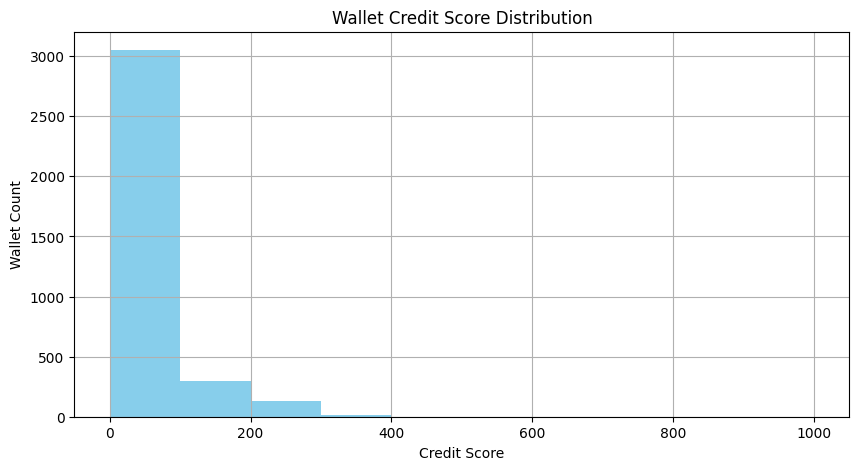

In [15]:
import matplotlib.pyplot as plt

# Plot histogram
wallet_stats['credit_score'].plot.hist(bins=10, figsize=(10,5), color='skyblue')
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Wallet Count')
plt.grid(True)
plt.show()
